# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


In [286]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

try:
    import urllib2 as ulib
except ImportError:
    import urllib3 as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError
    
from sklearn import preprocessing

import os

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['types']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
#environmental variable
#create the env variable since previous doesn't work
os.environ["PUIDATA"] = "%s/PUI2018/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/sjf374/PUI2018/PUIdata


In [4]:
ridefile = os.getenv("PUIDATA") + "/Ridetypes.png"

In [5]:
ridefile

'/nfshome/sjf374/PUI2018/PUIdata/Ridetypes.png'

In [6]:
!curl -O https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/Ridetypes.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12802  100 12802    0     0  83739      0 --:--:-- --:--:-- --:--:-- 84223


In [7]:
os.system("mv Ridetypes.png " + ridefile)

0

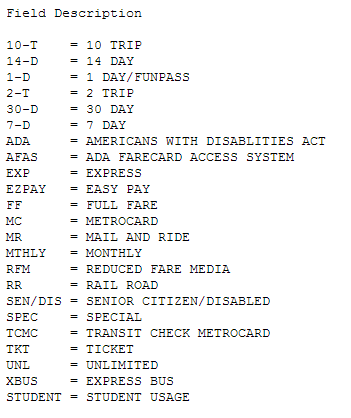

In [8]:
Image(filename = ridefile)

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [11]:
# response = urllib.urlopen('https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy')

In [12]:
# https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy

In [13]:
!curl -O https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   150  100   150    0     0    762      0 --:--:-- --:--:-- --:--:--   765


In [14]:
os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA") + "/MTA_Fare.npy")

0

In [15]:
os.getenv("PUIDATA")

'/nfshome/sjf374/PUI2018/PUIdata'

In [16]:
os.getenv("PUIDATA")+"/MTA_Fare.npy"

'/nfshome/sjf374/PUI2018/PUIdata/MTA_Fare.npy'

In [19]:
#np.load(os.getenv("PUIDATA")+"/MTA_Fare.npy")
#not working Trying in different way

IOError: Failed to interpret file '/nfshome/sjf374/PUI2018/PUIdata/MTA_Fare.npy' as a pickle

In [17]:
mta = np.load("MTA_Fare_py3.npy")

In [18]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [19]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [20]:
dates = pd.date_range(start= '5/19/2010', periods=194, freq='7D')

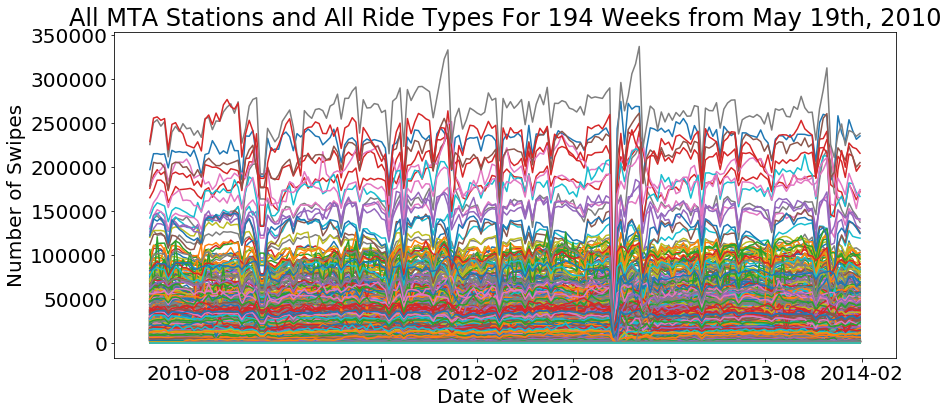

In [21]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for station in range(len(mta)):
    for ridetype in range(len(mta[station])):
        plt.plot(dates, mta[station,ridetype])


pl.xlabel('Date of Week')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

#### Plot 1: count of mta swipes per week per ride type. This is pretty messy. It will be best replotting with a cleaner version. It seems that there is something significant between 2011-08 and 2013-02 

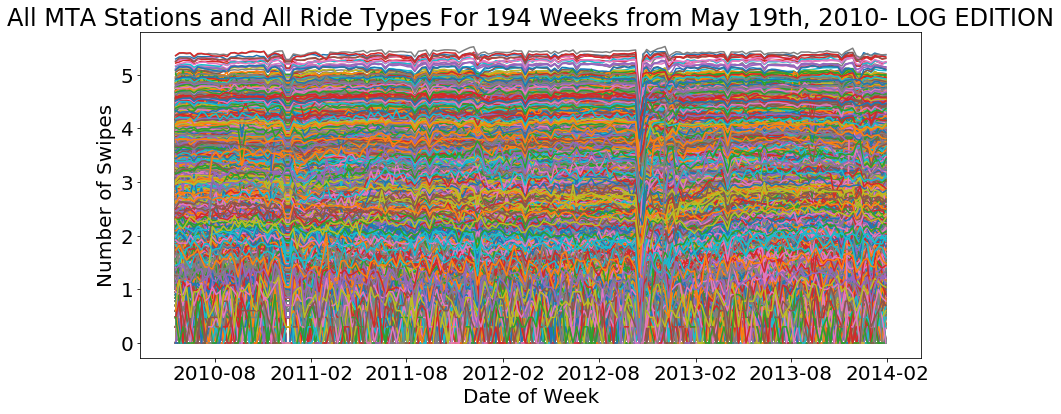

In [22]:
#computational extensive
pl.figure(figsize(14,6))

for station in range(len(mta)):
    for ridetype in range(len(mta[station])):
        plt.plot(dates, np.log10(mta[station,ridetype]))


pl.xlabel('Date of Week')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010- LOG EDITION')

#### Figure 2: time series for all ride types and all stations in semi-log space. The event as seen before, looks more prominent.  

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [23]:
#looking at FDNY deaths for clarifiction on how to do with pandas

In [24]:
## flatten the dataframe to sum over the wipes per station per week
mta_sum_by_card_types = np.nansum(mta, axis = 0)
mta_sum_by_wk = np.nansum(mta_sum_by_card_types, axis = 0)

In [25]:
np.shape(mta_sum_by_wk)

(194,)

In [26]:
mta_sum_by_wk

array([26716631, 29262313, 29597575, 29383978, 29182176, 26208052,
       28680022, 29122010, 28800200, 28595932, 28308361, 27927423,
       27268131, 28246743, 26683582, 30015142, 30180176, 29048486,
       30065000, 29168839, 30323454, 30186700, 29983681, 30049876,
       30125402, 25160821, 29185649, 30577220, 30103021, 27557647,
       21799403, 21792798, 27479553, 27108970, 26010345, 26430220,
       28656503, 29100353, 29573058, 26718018, 29176634, 29397046,
       29876972, 29673828, 29521768, 30172126, 30193061, 28496477,
       29031851, 30394695, 29988635, 29949834, 27144981, 29846497,
       30162349, 29975652, 30294451, 26740659, 29964051, 29471983,
       29249492, 29426206, 29059658, 27976524, 27921014, 22981394,
       28139307, 31992892, 32503085, 24294628, 32156059, 30744539,
       32638048, 32901236, 31950684, 32127913, 32474319, 27028024,
       31805789, 33120126, 33170696, 31931091, 24562552, 28046492,
       30001277, 28037318, 29384138, 31197426, 31670476, 31123

In [27]:
print ("mean rides by day {:.2f}".format(mta_sum_by_wk.mean()))
print ("stdev rides by day {:.2f}".format(mta_sum_by_wk.std()))
thresholds = [mta_sum_by_wk.mean() + 3 * mta_sum_by_wk.std(), 
              mta_sum_by_wk.mean() - 3 * mta_sum_by_wk.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean rides by day 29778001.61
stdev rides by day 2984034.35
3-sigma thresholds 38730104.65 20825898.56


In [28]:
log_thresholds = np.log10(thresholds)

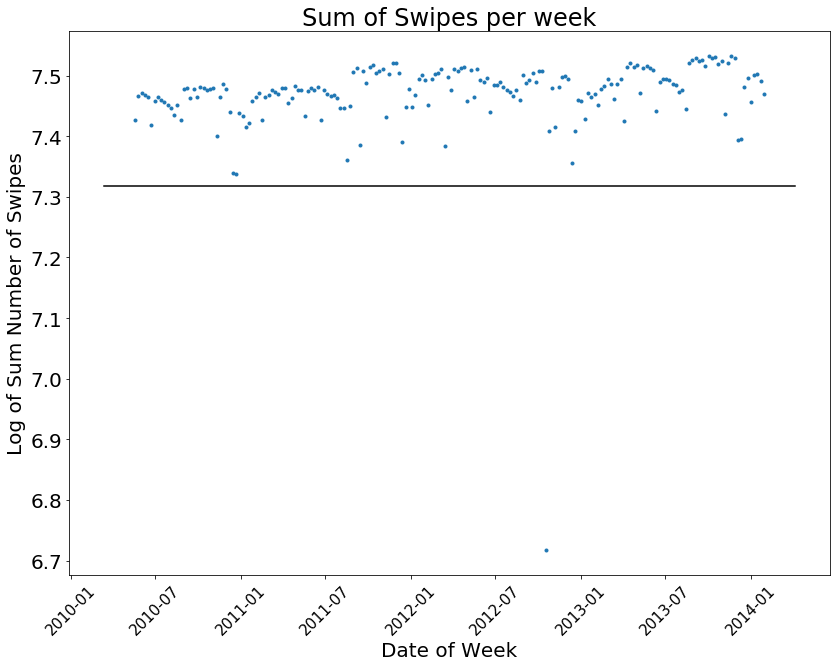

In [54]:
fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(121)
plt.title('Sum of Swipes per week')
ax.plot(dates, np.log10(mta_sum_by_wk), '.' )
pl.xticks(rotation=45, fontsize=15)
pl.xlabel('Date of Week')
pl.ylabel('Log of Sum Number of Swipes')
# ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]], color='k')
# -- too high to see the rest
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [log_thresholds[1], log_thresholds[1]], color='k')



Figure 3: date is clearly an outlier... let's see what that date it

In [32]:
mta[0][4]

array([358, 529, 422, 261, 248, 362, 479, 345, 192, 414, 432, 330, 218,
       323, 355, 454, 326, 251, 493, 489, 370, 230, 484, 476, 381, 181,
       344, 502, 437, 203,  72,  72, 490, 451, 331, 229, 397, 497, 402,
       206, 419, 510, 397, 279, 236, 475, 475, 225, 240, 470, 374, 243,
       335, 513, 427, 295, 279, 452, 508, 361, 238, 450, 444, 315, 255,
       239, 411, 497, 351, 213, 501, 465, 353, 293, 422, 469, 422, 193,
       333, 498, 414, 251,  99, 445, 506, 332, 257, 330, 463, 373, 200,
       303, 483, 448, 295, 175, 374, 367, 386, 250, 390, 490, 379, 290,
       252, 522, 546, 401, 310, 331, 548, 433, 325, 355, 415, 399, 271,
       228, 347, 451, 342, 277, 479, 438, 351, 282,   2,   0,  -1,  -1,
         0,  15,  26,  32,  12,  29,  50,  41,  36,  32,  54,  49,  36,
        30,  58,  49,  46,  36, 112, 204, 158, 213, 243, 248, 169, 155,
       254, 272, 173, 180, 179, 300, 260, 205, 193, 247, 245, 176, 149,
       162, 238, 211, 161, 231, 284, 196, 141, 168, 276, 273, 22

In [35]:
ride_by_week_df  = pd.DataFrame(mta_sum_by_wk, dates, columns = ['sum_of_rides'])

In [36]:
ride_by_week_df.sort(columns='sum_of_rides')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,sum_of_rides
2012-10-17,5215466
2010-12-22,21792798
2010-12-15,21799403
2012-12-12,22678387
2011-08-17,22981394
2012-03-14,24213348
2011-09-14,24294628
2011-12-14,24562552
2013-12-04,24803770
2013-12-11,24848340


In [37]:
ride_by_week_df.loc[(ride_by_week_df['sum_of_rides'] < thresholds[1])]

,sum_of_rides
2012-10-17,5215466


In [38]:
#that doesn't seem right.... let's try another way of detection found in a sample notebook from class

In [39]:
##single point change detector
# as in https://www.slideshare.net/FrankKelly3/changepoint-detection-with-bayesian-inference
# with modifications for efficiency

def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = data.cumsum()
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': np.nanmean(data[:changePoint+1]), 
            'meanAfter': np.nanmean(data[(changePoint+1):])}

In [40]:
pochange = changeFinder(mta[0][4])

In [41]:
pochange

{'meanAfter': 160.67164179104478,
 'meanBefore': 358.3937007874016,
 'pChange': array([-1395.89275725, -1394.84267271, -1394.14437818, -1393.91364522,
        -1394.60112713, -1395.0776306 , -1395.03293475, -1394.48989093,
        -1394.4964544 , -1395.06495624, -1394.79489782, -1394.42875491,
        -1394.45211116, -1394.86257731, -1394.88297255, -1394.79571051,
        -1394.36301155, -1394.37008719, -1394.62416954, -1394.04341803,
        -1393.41304943, -1393.23961624, -1393.62339594, -1392.99057368,
        -1392.34440458, -1392.10205102, -1392.73268913, -1392.64950375,
        -1391.88229606, -1391.36864542, -1391.91744761, -1392.93197317,
        -1393.79557743, -1393.20436006, -1392.71352362, -1392.66184622,
        -1392.98229823, -1392.6865167 , -1391.9921117 , -1391.64644216,
        -1392.08451981, -1391.67390205, -1390.86146662, -1390.50622263,
        -1390.6666509 , -1391.00109649, -1390.30891633, -1389.58039462,
        -1389.98779899, -1390.3095418 , -1389.60947164, -

In [42]:
dates[pochange['pointOfChange']]

Timestamp('2012-10-24 00:00:00', offset='7D')

HURRICANE SANDY

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


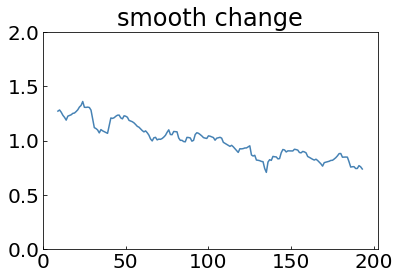

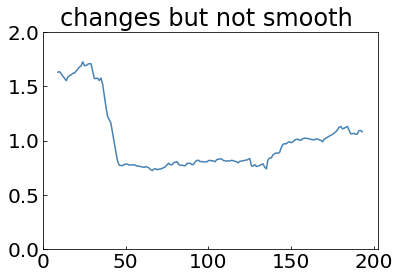

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [44]:
mta_avg_by_card_types = np.nanmean(mta, axis = 0)

In [45]:
shape(mta_avg_by_card_types)

(23, 194)

In [47]:
types = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']

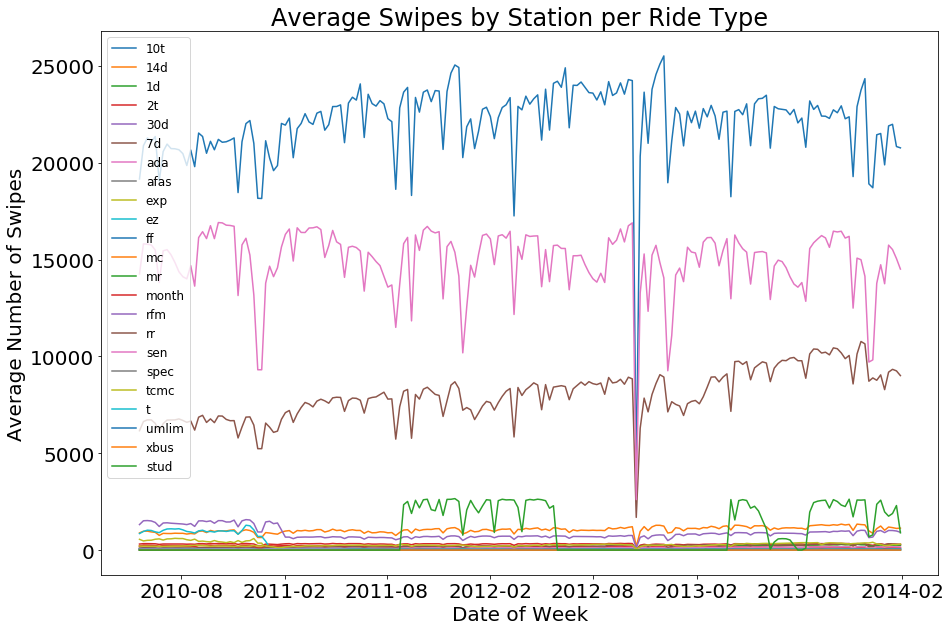

In [56]:
plt.figure(figsize = (15,10))
plt.title('Average Swipes by Station per Ride Type')
for x in mta_avg_by_card_types:
    plt.plot(dates, x)
plt.legend(types, loc=2, prop={'size': 12})
pl.xlabel('Date of Week')
pl.ylabel('Average Number of Swipes')

Figure 4: Grpahing the average without rolling mean. Some ride types are clearly more often used than others... for example the unlimited

In [60]:
shape(mta_avg_by_card_types)

(23, 194)

In [66]:
mta_avg_by_card_typesdf = pd.DataFrame(mta_avg_by_card_types, index = types, columns = dates).T #flip it so the dates are the index

In [73]:
rollingdf = mta_avg_by_card_typesdf.rolling(10, min_periods=5).mean()

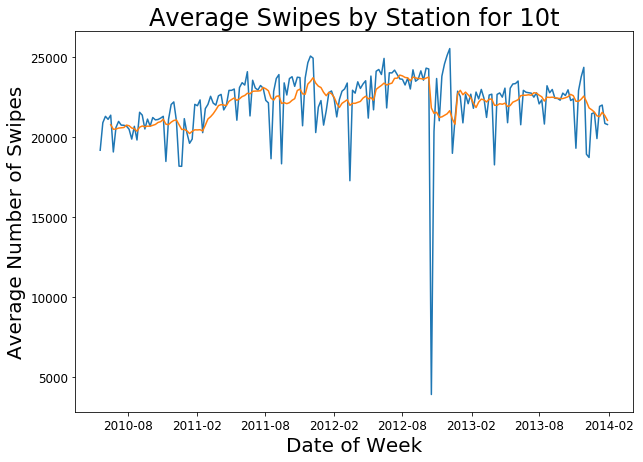

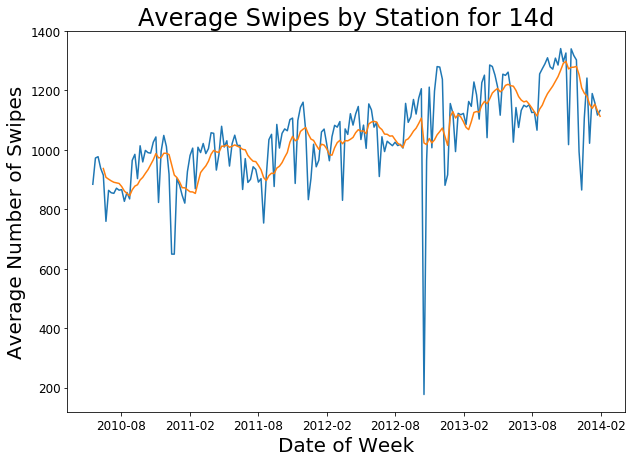

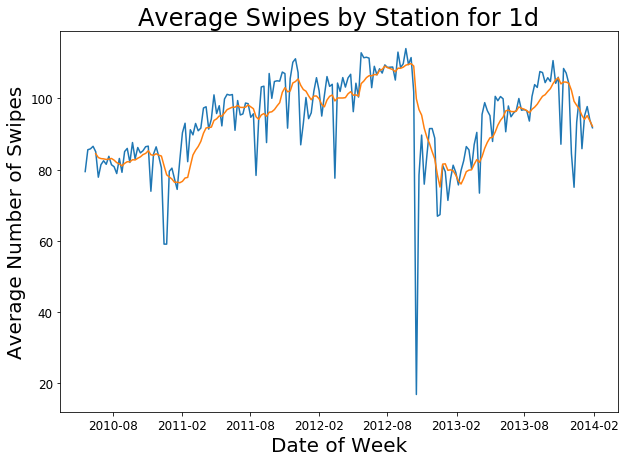

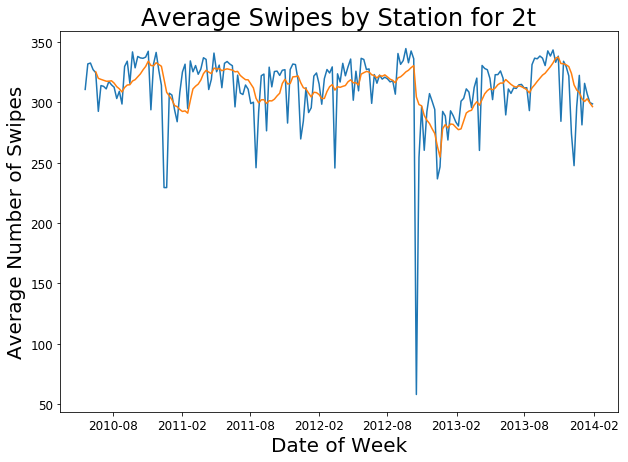

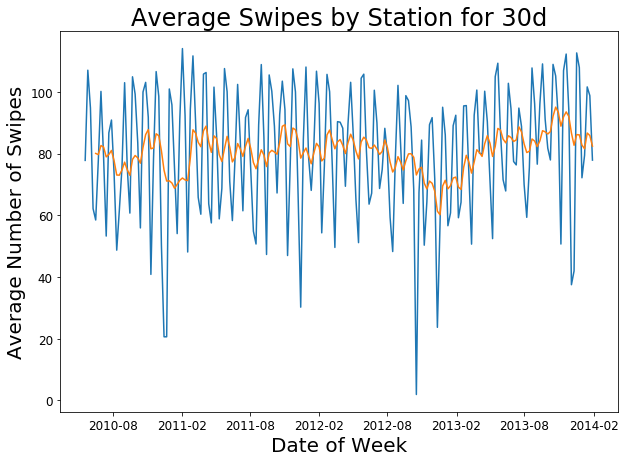

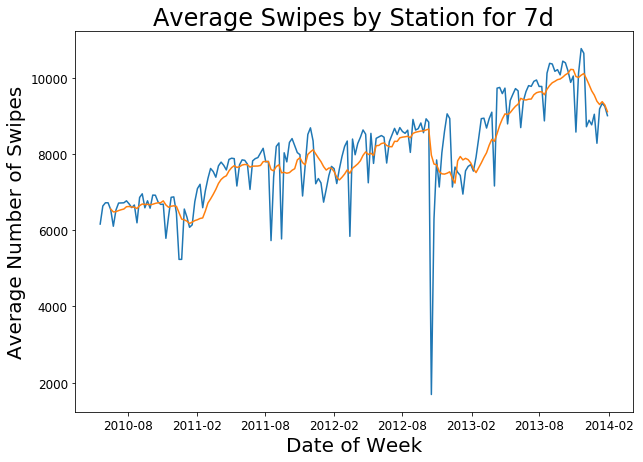

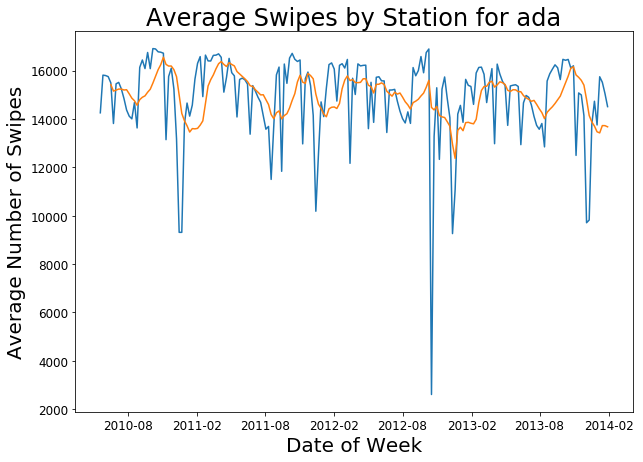

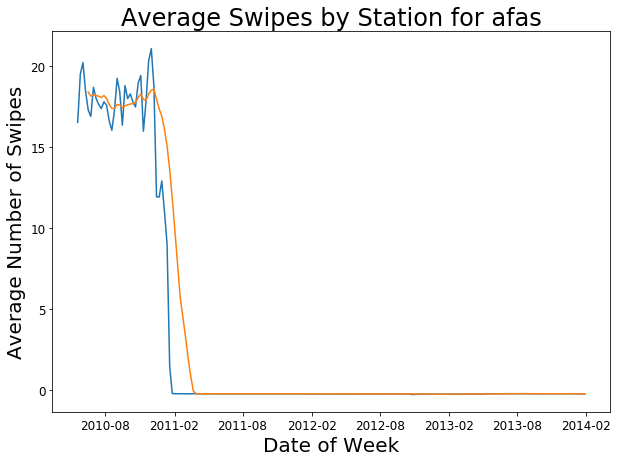

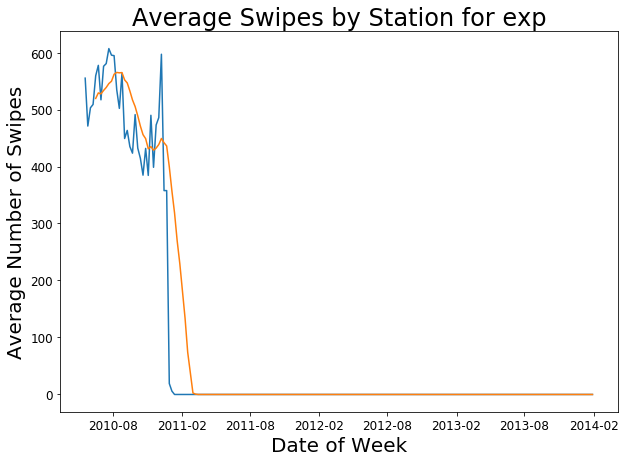

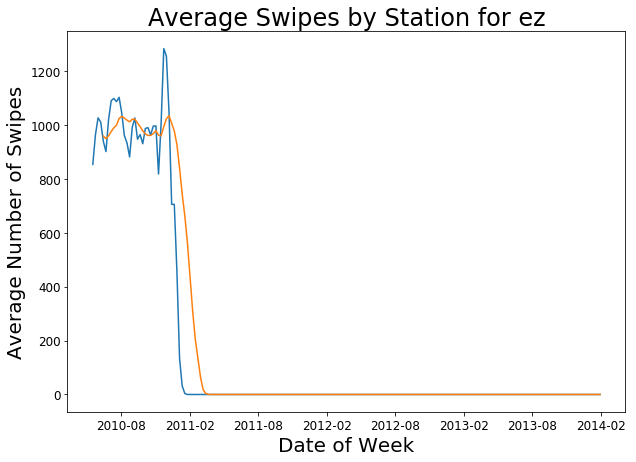

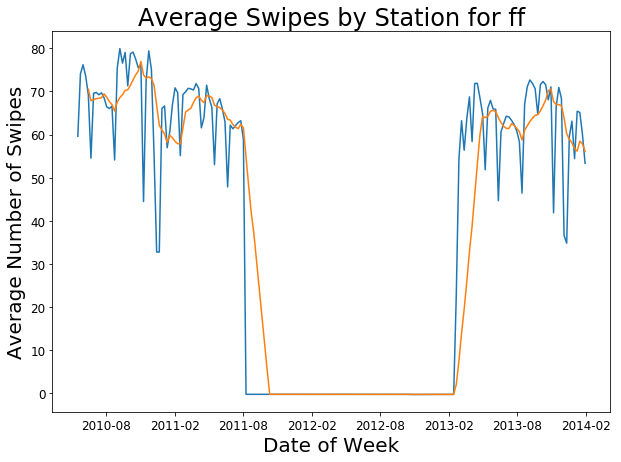

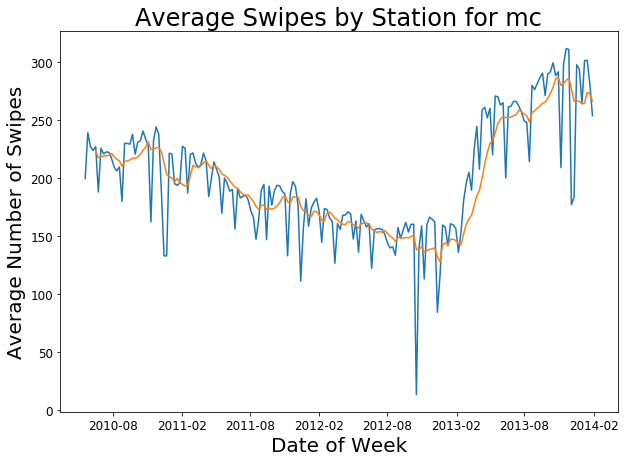

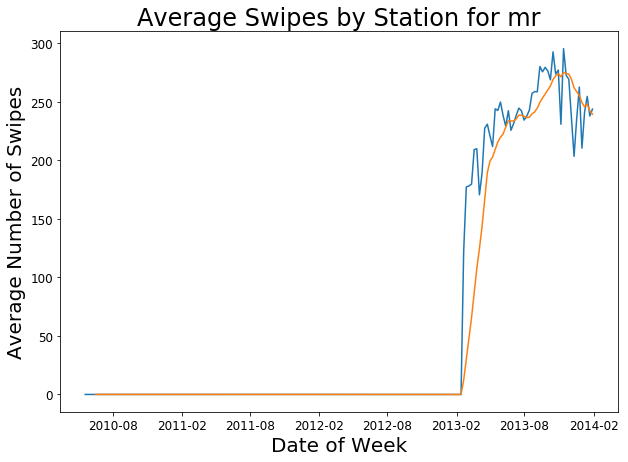

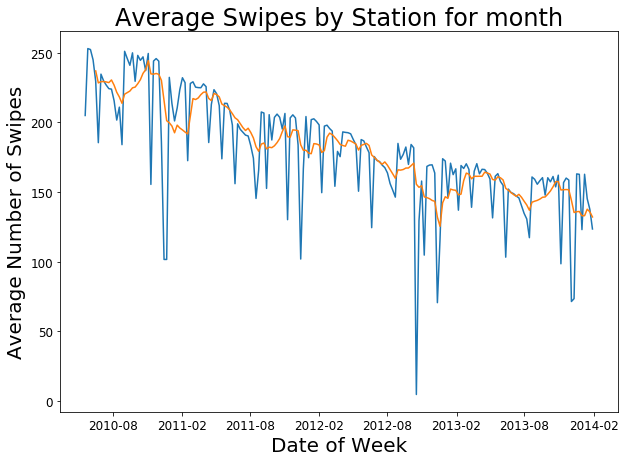

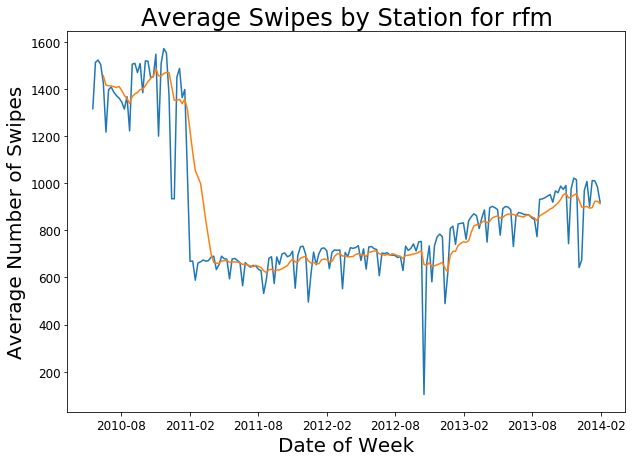

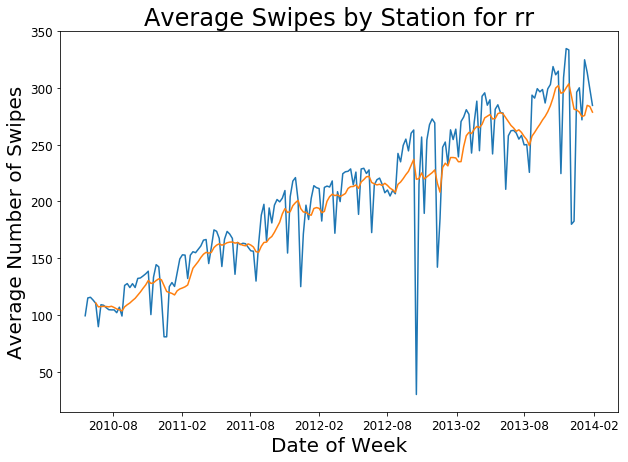

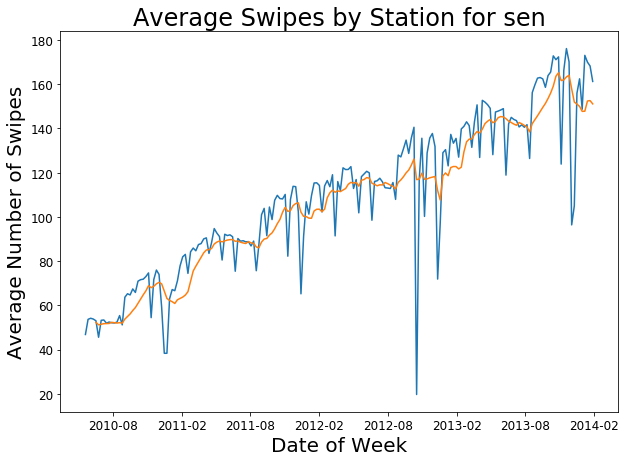

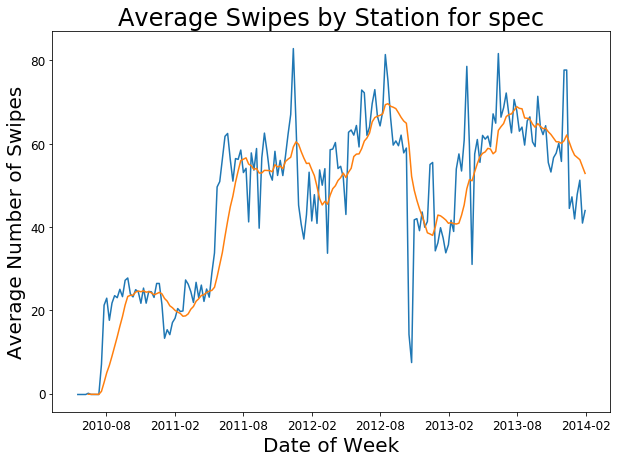

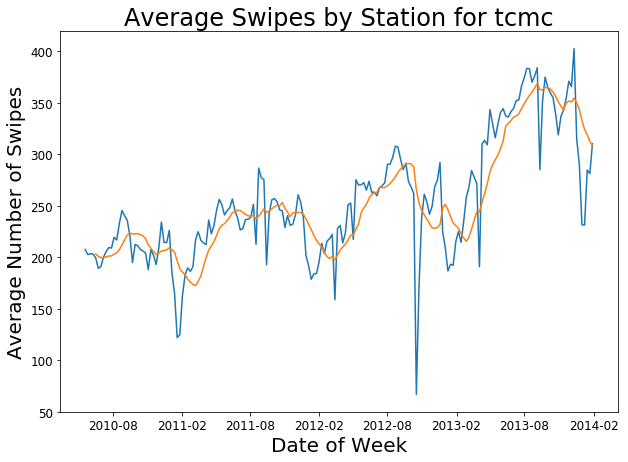

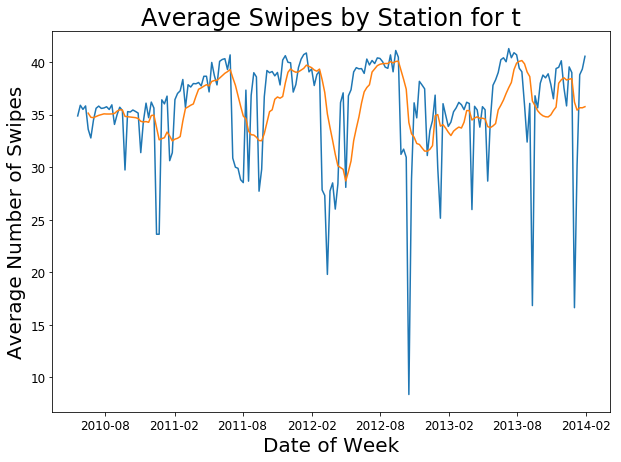

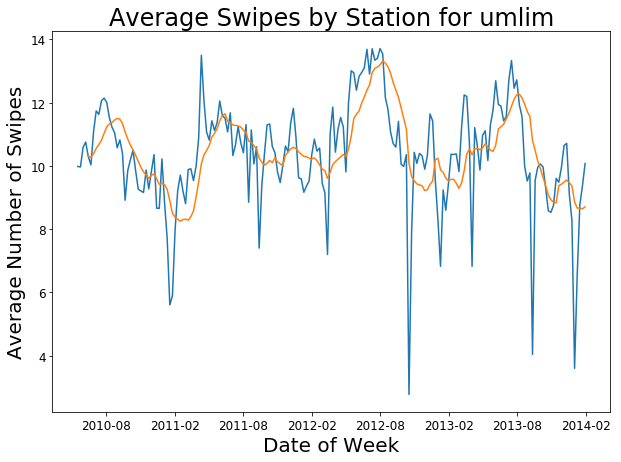

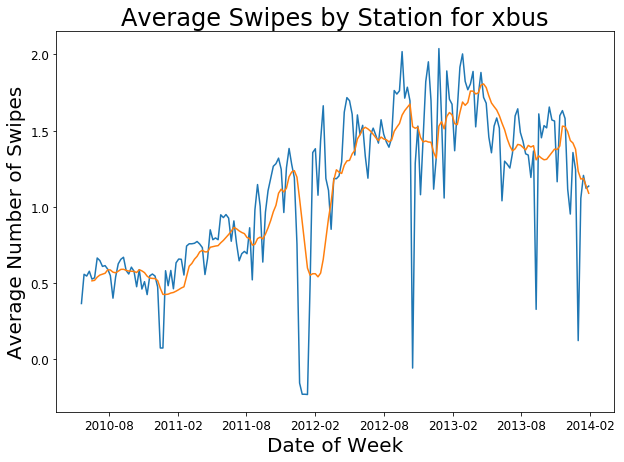

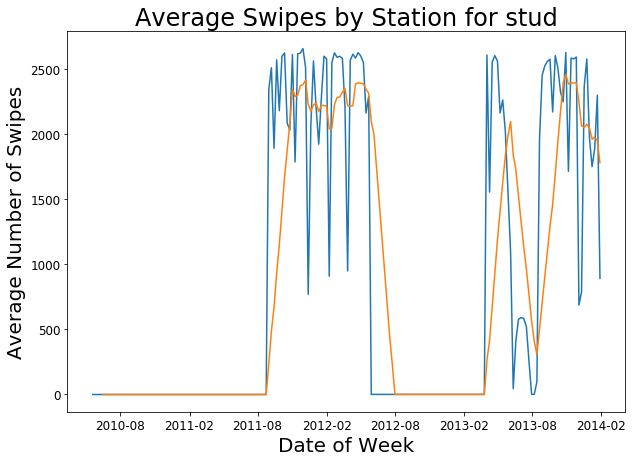

In [78]:
for i in range(len(mta_avg_by_card_types)):
    plt.figure(figsize = (10,7))
    plt.title('Average Swipes by Station for %s' % types[i])
    plt.plot(dates, mta_avg_by_card_types[i])
    #plt.legend(types, loc=2, prop={'size': 12})
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
    pl.xlabel('Date of Week')
    pl.ylabel('Average Number of Swipes')
    plt.plot(rollingdf[types[i]])

In [ ]:
Figure

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [90]:
mta[1][0]

array([16210, 20179, 21769, 19307, 18076, 15541, 18092, 17689, 17846,
       18056, 17997, 17509, 17094, 16796, 13841, 18324, 17955, 17456,
       17858, 16475, 17686, 17333, 16958, 16757, 17930, 12509, 17459,
       17411, 17530, 14192, 10492, 10488, 17280, 16225, 14865, 16070,
       17842, 18554, 18738, 14633, 18087, 20092, 19758, 17910, 18026,
       20438, 18451, 18212, 20572, 21296, 21092, 19105, 15639, 19224,
       19099, 19455, 20079, 16149, 20076, 19520, 19751, 19059, 19145,
       18595, 17489, 16880, 15601, 19618, 21030, 17560, 22353, 22085,
       21566, 19833, 20702, 19071, 19816, 15617, 19204, 16376, 15285,
       15603, 11642, 12915, 13811, 12609, 14066, 13515, 16332, 13609,
       11250, 14030, 13553, 13833, 14303, 11013, 14312, 14178, 14472,
       13996, 14559, 14311, 13944, 15818, 12960, 15251, 15046, 15088,
       15337, 12652,    40,    -1,    -1,    -1,    -1,    -1,    -1,
          -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
          -1,    -1,

In [81]:
shape(mta)

(600, 23, 194)

In [95]:
mta2d = mta.reshape(13800, 194)

In [96]:
shape(mta2d)

(13800, 194)

In [137]:
mta2d

array([[56961, 64703, 68002, ..., 36527, 33929, 36824],
       [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
       [  203,   276,   245, ...,   186,   167,   167],
       ..., 
       [   -1,    -1,    -1, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1]], dtype=int32)

In [134]:
mta2d[-1]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1], dtype=int32)

In [107]:
mta2d_floats = mta2d.astype(float) # to correct for error with nans

In [108]:
mta2d_floats[mta2d_floats == -1] = np.nan

In [109]:
mta2d_floats 

array([[ 56961.,  64703.,  68002., ...,  36527.,  33929.,  36824.],
       [  1732.,   2083.,   2107., ...,   1264.,   1172.,   1238.],
       [   203.,    276.,    245., ...,    186.,    167.,    167.],
       ..., 
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])

In [112]:
shape(mta2d_floats)

(13800, 194)

In [161]:
#https://stackoverflow.com/questions/18072759/list-comprehension-on-a-nested-list
shape([(station, ride) for ride in types for station in range(1,601)])

(13800, 2)

In [162]:
labels = [(station, ride) for ride in types for station in range(1,601)]
labelsarray = np.array(labels)

In [118]:
np.isnan(mta2d_floats)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [133]:
mta2d_floats[-10]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

In [144]:
mta2d_floats[0]

array([  5.69610000e+04,   6.47030000e+04,   6.80020000e+04,
         7.26280000e+04,   7.58660000e+04,   7.24330000e+04,
         7.11860000e+04,   7.14980000e+04,   7.38010000e+04,
         7.25170000e+04,   7.43850000e+04,   7.17800000e+04,
         6.31740000e+04,   6.64280000e+04,   6.21720000e+04,
         6.10270000e+04,   5.68640000e+04,   5.46120000e+04,
         5.53910000e+04,   5.87580000e+04,   5.36150000e+04,
         5.51530000e+04,   5.22410000e+04,   5.42370000e+04,
         5.63320000e+04,   5.20030000e+04,   5.82270000e+04,
         5.80110000e+04,   5.68410000e+04,   5.46230000e+04,
         5.51790000e+04,   5.51560000e+04,   6.18620000e+04,
         4.98310000e+04,   4.38510000e+04,   4.41640000e+04,
         5.21340000e+04,   5.31250000e+04,   5.54280000e+04,
         5.48260000e+04,   5.62090000e+04,   5.87000000e+04,
         6.64110000e+04,   6.20790000e+04,   6.05070000e+04,
         6.45710000e+04,   6.35480000e+04,   7.39870000e+04,
         6.98920000e+04,

In [163]:
new_mta2d_floats =  mta2d_floats[~np.isnan(mta2d_floats).any(axis=1)]

In [164]:
shape(new_mta2d_floats)

(9174, 194)

In [165]:
new_labels = labelsarray[~np.isnan(mta2d_floats).any(axis=1)]

In [166]:
shape(new_labels)

(9174, 2)

In [199]:
stations_rides = []
for x in new_labels:
    stations_rides.append((x[0], x[1]))

In [284]:
mta_df2 = pd.DataFrame(new_mta2d_floats, \
                       columns=dates, index=pd.MultiIndex.from_tuples(stations_rides, names=['stations','rides']))

In [285]:
mta_df2.head()

,,2010-05-19 00:00:00,2010-05-26 00:00:00,2010-06-02 00:00:00,2010-06-09 00:00:00,2010-06-16 00:00:00,2010-06-23 00:00:00,2010-06-30 00:00:00,2010-07-07 00:00:00,2010-07-14 00:00:00,2010-07-21 00:00:00,...,2013-11-27 00:00:00,2013-12-04 00:00:00,2013-12-11 00:00:00,2013-12-18 00:00:00,2013-12-25 00:00:00,2014-01-01 00:00:00,2014-01-08 00:00:00,2014-01-15 00:00:00,2014-01-22 00:00:00,2014-01-29 00:00:00
stations,rides,,,,,,,,,,,,,,,,,,,,,
47,10t,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3506.0,2894.0,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0
48,10t,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,192.0,167.0,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0
49,10t,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,21.0,17.0,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0
50,10t,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,25.0,18.0,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0
51,10t,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,2.0,1.0,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0


In [293]:
mta_df2.reset_index(inplace=True)

In [294]:
mta_df2[mta_df2['stations'] == '47'].iloc[:,2:10].values.mean()

3801.3235294117649

In [295]:
stationmeans = {}
for x in mta_df2['stations'].unique():
    stationmeans[x] = mta_df2[mta_df2['stations'] == x].iloc[:,2:10].values.mean()

In [296]:
stationstd = {}
for x in mta_df2['stations'].unique():
    stationstd[x] = mta_df2[mta_df2['stations'] == x].iloc[:,2:10].values.std()

In [297]:
#mean of each time series
mta_df2['mean'] = mta_df2.mean(axis = 1)

In [298]:
#std of each time series
mta_df2['std'] = mta_df2.std(axis = 1)

In [299]:
mta_df2['stationmeans'] = [stationmeans[x] for x in mta_df2['stations']]

In [300]:
mta_df2['stationstd'] = [stationstd[x] for x in mta_df2['stations']]

In [301]:
mta_df2.head()

,stations,rides,2010-05-19 00:00:00,2010-05-26 00:00:00,2010-06-02 00:00:00,2010-06-09 00:00:00,2010-06-16 00:00:00,2010-06-23 00:00:00,2010-06-30 00:00:00,2010-07-07 00:00:00,...,2013-12-25 00:00:00,2014-01-01 00:00:00,2014-01-08 00:00:00,2014-01-15 00:00:00,2014-01-22 00:00:00,2014-01-29 00:00:00,mean,std,stationmeans,stationstd
0,47,10t,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,...,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,3548.917526,391.400424,3801.323529,13017.450515
1,48,10t,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,...,204.0,166.0,191.0,212.0,209.0,211.0,144.587629,43.600755,4568.048611,10604.025558
2,49,10t,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,...,19.0,13.0,19.0,26.0,20.0,22.0,17.938144,8.137117,8209.933824,29613.980846
3,50,10t,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,...,25.0,29.0,31.0,28.0,24.0,22.0,30.257732,9.809819,2331.944444,5514.675349
4,51,10t,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,8.0,6.0,5.0,5.0,6.0,0.0,2.896907,4.235307,6530.875000,18285.610911


In [302]:
#the time series mean divided by the mean of all time series for that station
mta_df2['mean_ratio'] = mta_df2['mean']/mta_df2['stationmeans']

In [303]:
#the time series standard deviation by the standard deviation of all time series for that station
mta_df2['std_ratio'] = mta_df2['std']/mta_df2['stationstd']

In [315]:
#used min max scaler before to standardize. this puts everything on the same scale 
#https://stackoverflow.com/questions/43458593/python-pandas-standardize-column-for-regression

In [308]:
#the slope and intercept of a line fit to the standardized time series
x = mta_df2.iloc[:,2:].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)


In [310]:
mta_df2.columns[2:]

Index([2010-05-19 00:00:00, 2010-05-26 00:00:00, 2010-06-02 00:00:00,
       2010-06-09 00:00:00, 2010-06-16 00:00:00, 2010-06-23 00:00:00,
       2010-06-30 00:00:00, 2010-07-07 00:00:00, 2010-07-14 00:00:00,
       2010-07-21 00:00:00,
       ...
       2014-01-08 00:00:00, 2014-01-15 00:00:00, 2014-01-22 00:00:00,
       2014-01-29 00:00:00,             u'mean',              u'std',
           u'stationmeans',       u'stationstd',       u'mean_ratio',
              u'std_ratio'],
      dtype='object', length=200)

In [311]:
mta_df3 = pd.DataFrame(x_scaled, columns = mta_df2.columns[2:])

In [313]:
mta_df3['stations'] = mta_df2['stations']
mta_df3['rides'] = mta_df2['rides']

In [314]:
mta_df3.head()

,2010-05-19 00:00:00,2010-05-26 00:00:00,2010-06-02 00:00:00,2010-06-09 00:00:00,2010-06-16 00:00:00,2010-06-23 00:00:00,2010-06-30 00:00:00,2010-07-07 00:00:00,2010-07-14 00:00:00,2010-07-21 00:00:00,...,2014-01-22 00:00:00,2014-01-29 00:00:00,mean,std,stationmeans,stationstd,mean_ratio,std_ratio,stations,rides
0,0.014369,0.013406,0.014113,0.011088,0.014160,0.011837,0.011454,0.011166,0.011906,0.014398,...,0.014491,0.013494,0.013648,0.013796,0.215392,0.219588,0.052464,0.008526,47,10t
1,0.000480,0.000360,0.000397,0.000312,0.000364,0.000337,0.000290,0.000367,0.000400,0.000381,...,0.000889,0.000885,0.000556,0.001537,0.261434,0.177619,0.001779,0.001166,48,10t
2,0.000031,0.000023,0.000051,0.000028,0.000020,0.000032,0.000028,0.000024,0.000012,0.000016,...,0.000085,0.000092,0.000069,0.000287,0.480134,0.508199,0.000123,0.000078,49,10t
3,0.000179,0.000199,0.000183,0.000146,0.000196,0.000196,0.000177,0.000128,0.000177,0.000229,...,0.000102,0.000092,0.000116,0.000346,0.127154,0.089116,0.000729,0.000504,50,10t
4,0.000000,0.000000,0.000000,0.000000,0.000004,0.000005,0.000000,0.000000,0.000000,0.000008,...,0.000026,0.000000,0.000011,0.000149,0.379304,0.311200,0.000025,0.000066,51,10t


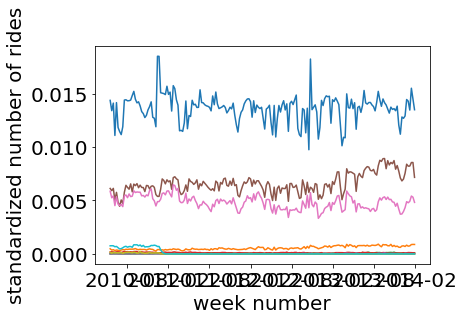

In [318]:
standardizedts = mta_df3.iloc[:,:-8].T
plt.
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [ ]:
#doesnt seem to match... lets try again

In [342]:
mta_df2.head()

,stations,rides,2010-05-19 00:00:00,2010-05-26 00:00:00,2010-06-02 00:00:00,2010-06-09 00:00:00,2010-06-16 00:00:00,2010-06-23 00:00:00,2010-06-30 00:00:00,2010-07-07 00:00:00,...,2014-01-08 00:00:00,2014-01-15 00:00:00,2014-01-22 00:00:00,2014-01-29 00:00:00,mean,std,stationmeans,stationstd,mean_ratio,std_ratio
0,47,10t,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,...,3418.0,3746.0,3406.0,3217.0,3548.917526,391.400424,3801.323529,13017.450515,0.933600,0.030067
1,48,10t,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,...,191.0,212.0,209.0,211.0,144.587629,43.600755,4568.048611,10604.025558,0.031652,0.004112
2,49,10t,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,...,19.0,26.0,20.0,22.0,17.938144,8.137117,8209.933824,29613.980846,0.002185,0.000275
3,50,10t,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,...,31.0,28.0,24.0,22.0,30.257732,9.809819,2331.944444,5514.675349,0.012975,0.001779
4,51,10t,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,5.0,5.0,6.0,0.0,2.896907,4.235307,6530.875000,18285.610911,0.000444,0.000232


In [337]:
mta_df3 = mta_df2.iloc[:,2:-6].sub(mta_df2.iloc[:,2:-6].mean(axis=1), axis=0)/mta_df2.iloc[:,2:-6].sub(mta_df2.iloc[:,2:-6].std(axis=1), axis=0)

In [338]:
mta_df3.head()

,2010-05-19 00:00:00,2010-05-26 00:00:00,2010-06-02 00:00:00,2010-06-09 00:00:00,2010-06-16 00:00:00,2010-06-23 00:00:00,2010-06-30 00:00:00,2010-07-07 00:00:00,2010-07-14 00:00:00,2010-07-21 00:00:00,...,2013-11-27 00:00:00,2013-12-04 00:00:00,2013-12-11 00:00:00,2013-12-18 00:00:00,2013-12-25 00:00:00,2014-01-01 00:00:00,2014-01-08 00:00:00,2014-01-15 00:00:00,2014-01-22 00:00:00,2014-01-29 00:00:00
0,-0.088605,-0.039491,0.024743,-0.306724,0.020202,-0.429196,-0.285438,-0.312156,-0.264835,0.013157,...,-0.013784,-0.261801,-0.380444,-0.071969,0.015619,-0.095785,-0.043270,0.058768,-0.047424,-0.117510
1,-0.521790,-1.089077,-0.730661,-1.858721,-1.046690,-2.330668,-2.566164,-1.089077,-0.893053,-0.966876,...,0.319735,0.181791,0.132538,0.259838,0.370664,0.175100,0.315116,0.400581,0.389701,0.396998
2,9.444333,5.531605,-1.019892,9.444333,4.096722,9.444333,9.444333,5.531605,2.896016,3.351990,...,0.238428,-0.106103,0.006285,0.174116,0.097941,-1.019892,0.097941,0.451851,0.174116,0.293448
3,0.344692,0.503884,0.450487,0.248199,0.491532,0.384211,0.402235,0.078605,0.384211,0.566996,...,-0.346706,-1.501290,-0.441780,-1.009143,-0.346706,-0.065627,0.035071,-0.124292,-0.441780,-0.678822
4,0.682225,0.682225,0.682225,0.682225,0.584335,0.584335,0.682225,0.682225,0.682225,0.399288,...,0.399288,0.584335,0.584335,1.234519,1.359471,1.769420,2.790229,2.790229,1.769420,0.682225


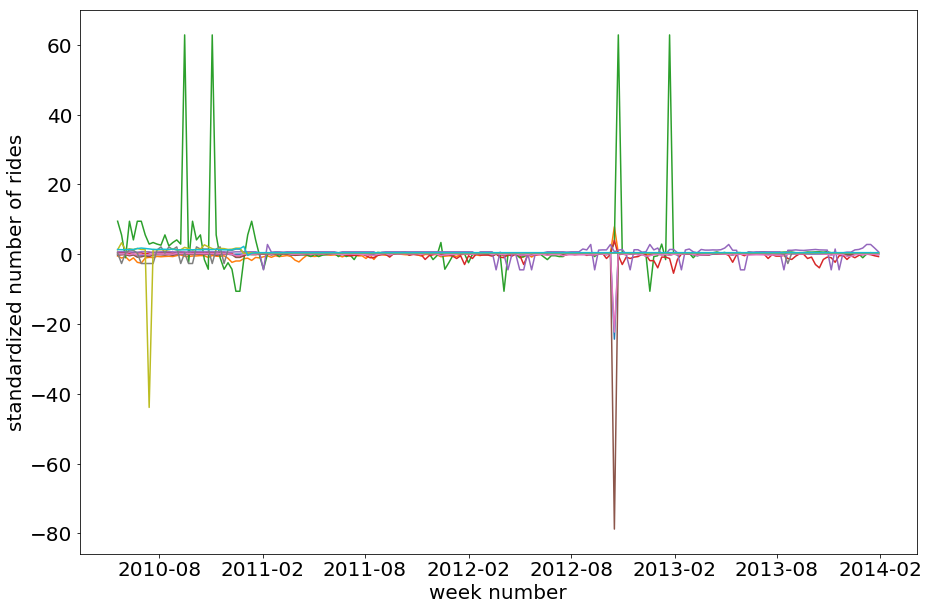

In [341]:
standardizedts = mta_df3.T
plt.figure(figsize=(15,10))
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")
plt.title('Standardize rides ')

Figure: Standardized amounts subtracts mean and divides by standard deviation. This gets rid of noise and shows true difference

In [34]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

[71890.84869151471,
 2091.2375892149093,
 282.7639968279143,
 915.9172085646317,
 407.4856463124503,
 21297.24948453608,
 41997.96748612212,
 29.473909595559086,
 3439.0558287073763,
 1505.7963521015074]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

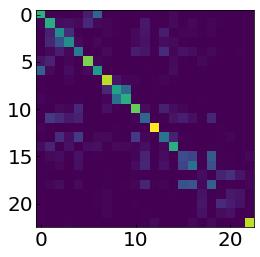

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

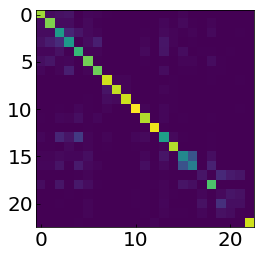

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   